In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gq-implied-volatility-forecasting/submission.csv
/kaggle/input/gq-implied-volatility-forecasting/test/SHIB.csv
/kaggle/input/gq-implied-volatility-forecasting/test/ETH.csv
/kaggle/input/gq-implied-volatility-forecasting/test/LINK.csv
/kaggle/input/gq-implied-volatility-forecasting/test/SOL.csv
/kaggle/input/gq-implied-volatility-forecasting/test/DOT.csv
/kaggle/input/gq-implied-volatility-forecasting/test/BTC.csv
/kaggle/input/gq-implied-volatility-forecasting/test/DOGE.csv
/kaggle/input/gq-implied-volatility-forecasting/train/SHIB.csv
/kaggle/input/gq-implied-volatility-forecasting/train/ETH.csv
/kaggle/input/gq-implied-volatility-forecasting/train/LINK.csv
/kaggle/input/gq-implied-volatility-forecasting/train/SOL.csv
/kaggle/input/gq-implied-volatility-forecasting/train/DOT.csv
/kaggle/input/gq-implied-volatility-forecasting/train/BTC.csv
/kaggle/input/gq-implied-volatility-forecasting/train/DOGE.csv


STARTING IV FORECASTING PIPELINE
1. Loading data...
Train data shape: (631292, 23)
Test data shape: (270548, 22)


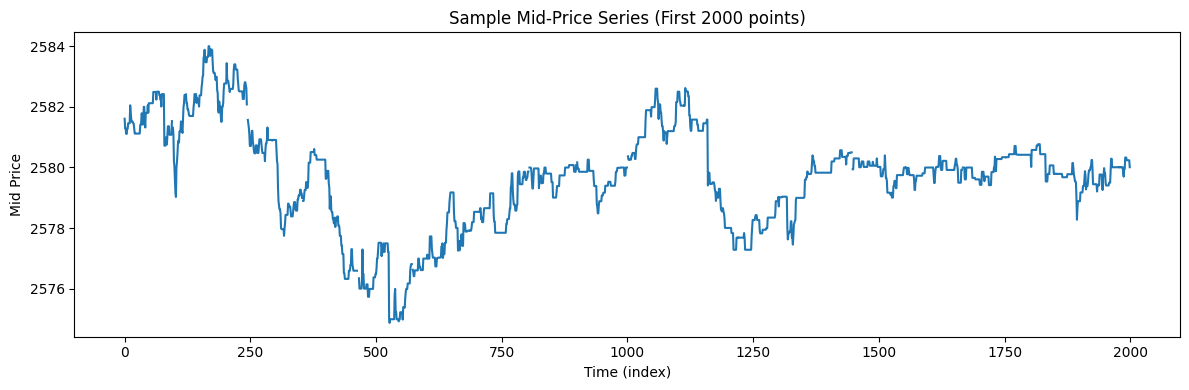

2. Feature engineering...
Starting feature engineering...
Feature engineering done. Column count: 152
Features ready (count=150), preparing target transformations...
Created 6 target transforms.
Training and evaluating models on validation fold for target selection...
Target: original, Correlation: 0.6157
Target: log, Correlation: 0.4285
Target: sqrt, Correlation: 0.6765
Target: quantile_normal, Correlation: 0.5373
Target: smooth_3, Correlation: 0.6266
Target: smooth_5, Correlation: 0.6702
Selected target transform: sqrt with correlation: 0.6765
Training ensemble models...
Ensemble validation correlation: 0.7004
Generating test predictions...
Submission saved as submission.csv
Prediction stats -- mean: 0.007501, std: 0.002149, min: 0.000848, max: 0.016359


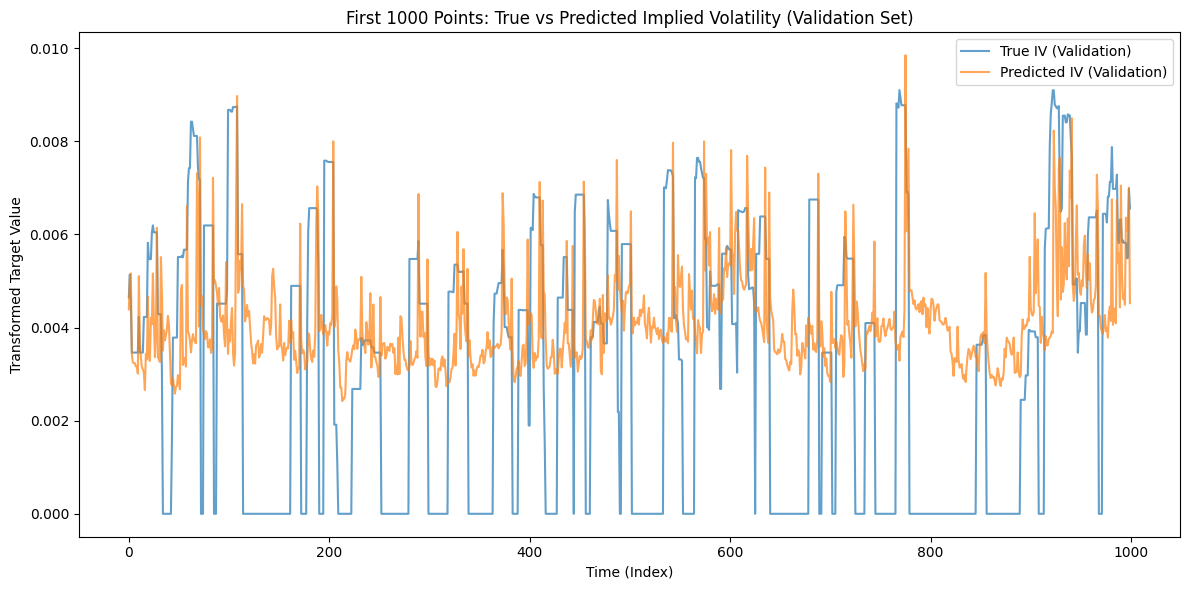

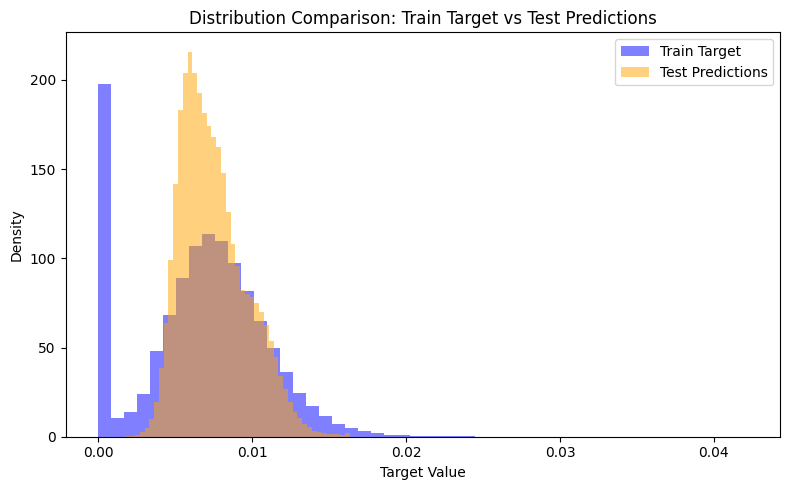

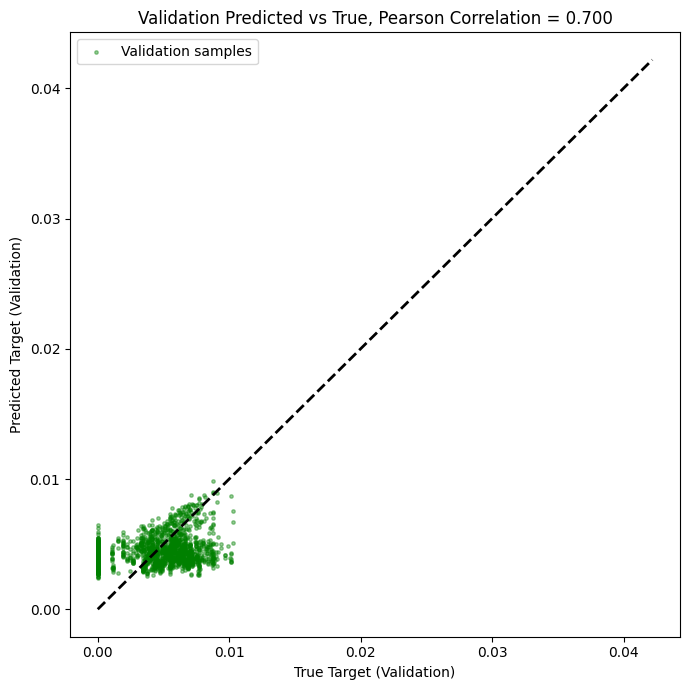

Pipeline runtime (minutes): 32.49
Number of features: 150
Best target transform: sqrt
Best single model validation correlation: 0.6765
Ensemble validation correlation: 0.7004


In [4]:
# ---------------------------------------
# RESTRUCTURED PIPELINE FOR SUBMISSION
# ---------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import time

try:
    from lightgbm import LGBMRegressor, early_stopping, log_evaluation
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'lightgbm'])
    from lightgbm import LGBMRegressor, early_stopping, log_evaluation

try:
    from catboost import CatBoostRegressor
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import QuantileTransformer
from scipy.stats import pearsonr

print("STARTING IV FORECASTING PIPELINE")
start_time = time.time()

# ---------------------------
# 1. LOAD DATA
# ---------------------------
print("1. Loading data...")
def try_load_data():
    train_paths =["/kaggle/input/gq-implied-volatility-forecasting/train/ETH.csv"]
    test_paths =["/kaggle/input/gq-implied-volatility-forecasting/test/ETH.csv"]
    
    train_data = None
    test_data = None
    for path in train_paths:
        try:
            train_data = pd.read_csv(path)
            break
        except:
            continue
    for path in test_paths:
        try:
            test_data = pd.read_csv(path)
            break
        except:
            continue
    
    return train_data, test_data

train, test = try_load_data()
if train is None:
    raise FileNotFoundError("Training data not found.")
if 'label' not in train.columns:
    raise ValueError("Train dataset has no 'label' column.")

print(f"Train data shape: {train.shape}")
print(f"Test data shape: {test.shape}")

# Plot sample price series
plt.figure(figsize=(12, 4))
plt.plot(train['mid_price'].head(2000))
plt.title("Sample Mid-Price Series (First 2000 points)")
plt.xlabel("Time (index)")
plt.ylabel("Mid Price")
plt.tight_layout()
plt.show()
# ---------------------------
# 2. FEATURE ENGINEERING
# ---------------------------
print("2. Feature engineering...")
def create_robust_features(df):
    df = df.copy()
    df['mid_return'] = df['mid_price'].pct_change().fillna(0)
    df['mid_log_return'] = np.log(df['mid_price'] / df['mid_price'].shift(1)).fillna(0)
    for lag in [1, 2, 3, 5]:
        df[f'price_momentum_{lag}'] = df['mid_price'] / (df['mid_price'].shift(lag) + 1e-8)
    df['spread'] = df['ask_price1'] - df['bid_price1']
    df['relative_spread'] = df['spread'] / (df['mid_price'] + 1e-8)
    df['log_spread'] = np.log(df['spread'] + 1e-8)
    for i in range(1, 5):
        df[f'spread_level_{i}'] = df[f'ask_price{i}'] - df[f'bid_price{i}']
        df[f'relative_spread_{i}'] = df[f'spread_level_{i}'] / (df['mid_price'] + 1e-8)
    bid_cols = [f'bid_price{i}' for i in range(1, 6)]
    bid_vols = [f'bid_volume{i}' for i in range(1, 6)]
    ask_cols = [f'ask_price{i}' for i in range(1, 6)]
    ask_vols = [f'ask_volume{i}' for i in range(1, 6)]
    total_bid_volume = sum(df[v] for v in bid_vols)
    total_ask_volume = sum(df[v] for v in ask_vols)
    df['VWAP_bid'] = sum(df[p] * df[v] for p,v in zip(bid_cols,bid_vols)) / (total_bid_volume + 1e-6)
    df['VWAP_ask'] = sum(df[p] * df[v] for p,v in zip(ask_cols,ask_vols)) / (total_ask_volume + 1e-6)
    df['VWAP_mid'] = (df['VWAP_bid'] + df['VWAP_ask']) / 2
    df['total_volume'] = total_bid_volume + total_ask_volume
    df['volume_imbalance'] = (total_bid_volume - total_ask_volume) / (total_bid_volume + total_ask_volume + 1e-6)
    df['volume_ratio'] = total_bid_volume / (total_ask_volume + 1e-6)
    df['weighted_bid_price'] = sum(df[f'bid_price{i}'] * df[f'bid_volume{i}'] for i in range(1, 4)) / (sum(df[f'bid_volume{i}'] for i in range(1, 4)) + 1e-6)
    df['weighted_ask_price'] = sum(df[f'ask_price{i}'] * df[f'ask_volume{i}'] for i in range(1, 4)) / (sum(df[f'ask_volume{i}'] for i in range(1, 4)) + 1e-6)
    df['weighted_mid'] = (df['weighted_bid_price'] + df['weighted_ask_price']) / 2
    windows = [3, 5, 10, 20, 50, 100]
    for w in windows:
        df[f'realized_vol_{w}'] = df['mid_return'].rolling(w, min_periods=1).std().fillna(0)
        df[f'log_vol_{w}'] = np.log(df[f'realized_vol_{w}'] + 1e-8)
        if w > 5:
            df[f'vol_ratio_{w}_5'] = df[f'realized_vol_{w}'] / (df['realized_vol_5'] + 1e-8)
        df[f'return_mean_{w}'] = df['mid_return'].rolling(w, min_periods=1).mean().fillna(0)
        df[f'spread_mean_{w}'] = df['relative_spread'].rolling(w, min_periods=1).mean().fillna(0)
        df[f'spread_std_{w}'] = df['relative_spread'].rolling(w, min_periods=1).std().fillna(0)
        df[f'volume_mean_{w}'] = df['total_volume'].rolling(w, min_periods=1).mean().fillna(0)
        df[f'volume_std_{w}'] = df['total_volume'].rolling(w, min_periods=1).std().fillna(0)
        df[f'imbalance_mean_{w}'] = df['volume_imbalance'].rolling(w, min_periods=1).mean().fillna(0)
        df[f'imbalance_std_{w}'] = df['volume_imbalance'].rolling(w, min_periods=1).std().fillna(0)
    df['return_spread'] = df['mid_return'] * df['relative_spread']
    df['return_volume'] = df['mid_return'] * np.log(df['total_volume'] + 1)
    df['return_vol'] = df['mid_return'] * df['realized_vol_20']
    df['spread_volume'] = df['relative_spread'] * np.log(df['total_volume'] + 1)
    df['spread_vol'] = df['relative_spread'] * df['realized_vol_20']
    df['volume_vol'] = np.log(df['total_volume'] + 1) * df['realized_vol_20']
    df['imbalance_vol'] = df['volume_imbalance'] * df['realized_vol_20']
    df['imbalance_spread'] = df['volume_imbalance'] * df['relative_spread']
    df['return_squared'] = df['mid_return'] ** 2
    df['return_abs'] = np.abs(df['mid_return'])
    df['spread_squared'] = df['relative_spread'] ** 2
    df['imbalance_squared'] = df['volume_imbalance'] ** 2
    for lag in [1, 2, 3, 5, 10]:
        df[f'return_momentum_{lag}'] = df['mid_return'] / (df['mid_return'].shift(lag).abs() + 1e-8)
        df[f'vol_momentum_{lag}'] = df['realized_vol_20'] / (df['realized_vol_20'].shift(lag) + 1e-8)
        df[f'spread_momentum_{lag}'] = df['relative_spread'] / (df['relative_spread'].shift(lag) + 1e-8)
    df['vol_percentile_100'] = df['realized_vol_20'].rolling(100, min_periods=10).rank(pct=True).fillna(0.5)
    df['vol_regime_high'] = (df['vol_percentile_100'] > 0.8).astype(int)
    df['vol_regime_low'] = (df['vol_percentile_100'] < 0.2).astype(int)
    delta = df['mid_price'].diff()
    gain = delta.where(delta > 0, 0).rolling(14, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14, min_periods=1).mean()
    rs = gain / (loss + 1e-8)
    df['rsi'] = 100 - (100 / (1 + rs))
    df['rsi_normalized'] = (df['rsi'] - 50) / 50
    df['price_ma_20'] = df['mid_price'].rolling(20, min_periods=1).mean()
    df['price_std_20'] = df['mid_price'].rolling(20, min_periods=1).std()
    df['bb_position'] = (df['mid_price'] - df['price_ma_20']) / (df['price_std_20'] + 1e-8)
    df['bb_width'] = df['price_std_20'] / (df['price_ma_20'] + 1e-8)
    for lag in [1, 2, 3]:
        df[f'vol_lag_{lag}'] = df['realized_vol_20'].shift(lag).fillna(0)
        df[f'spread_lag_{lag}'] = df['relative_spread'].shift(lag).fillna(0)
        df[f'imbalance_lag_{lag}'] = df['volume_imbalance'].shift(lag).fillna(0)
    df = df.replace([np.inf, -np.inf], 0)
    df = df.fillna(0)
    return df

print("Starting feature engineering...")
train_processed = create_robust_features(train)
test_processed = create_robust_features(test)
print(f"Feature engineering done. Column count: {train_processed.shape[1]}")

# ---------------------------
# 3. PREPARE TRAIN & TARGET
# ---------------------------
feature_cols = [c for c in train_processed.columns if c not in ['timestamp', 'label']]
X = train_processed[feature_cols]
X_test = test_processed[feature_cols]

print(f"Features ready (count={len(feature_cols)}), preparing target transformations...")

def create_target_transforms(df, target_col='label'):
    from sklearn.preprocessing import QuantileTransformer
    trans = {}
    trans['original'] = df[target_col].copy()
    trans['log'] = np.log(df[target_col] + 1e-8)
    min_val = df[target_col].min()
    if min_val >= 0:
        trans['sqrt'] = np.sqrt(df[target_col])
    else:
        trans['sqrt'] = np.sqrt(df[target_col] - min_val + 1e-8)
    try:
        qt = QuantileTransformer(output_distribution='normal', n_quantiles=min(1000, len(df)//10))
        qn = qt.fit_transform(df[[target_col]]).flatten()
        trans['quantile_normal'] = pd.Series(qn, index=df.index)
    except:
        pass
    trans['smooth_3'] = df[target_col].rolling(3, center=True, min_periods=1).mean()
    trans['smooth_5'] = df[target_col].rolling(5, center=True, min_periods=1).mean()
    return trans

target_transforms = create_target_transforms(train_processed)
print(f"Created {len(target_transforms)} target transforms.")

# ---------------------------
# 4. TIME-SERIES SPLIT AND MODEL TRAINING
# ---------------------------
tscv = TimeSeriesSplit(n_splits=3)
train_idx, val_idx = list(tscv.split(X))[-1]
X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]

best_corr = -np.inf
best_target = None

print("Training and evaluating models on validation fold for target selection...")

for name, y_full in target_transforms.items():
    if not isinstance(y_full, pd.Series):
        y_full = pd.Series(y_full, index=train_processed.index)
    y_train = y_full.iloc[train_idx]
    y_val = y_full.iloc[val_idx]
    model = LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31,
        random_state=42,
        verbose=-1
    )
    model.fit(X_train, y_train)
    pred_val = model.predict(X_val)
    mask = np.isfinite(y_val) & np.isfinite(pred_val)
    if mask.sum() > 100:
        corr = pearsonr(y_val[mask], pred_val[mask])[0]
        print(f"Target: {name}, Correlation: {corr:.4f}")
        if corr > best_corr:
            best_corr = corr
            best_target = name

print(f"Selected target transform: {best_target} with correlation: {best_corr:.4f}")

y_best = target_transforms[best_target]
if not isinstance(y_best, pd.Series):
    y_best = pd.Series(y_best, index=train_processed.index)
y_train_best = y_best.iloc[train_idx]
y_val_best = y_best.iloc[val_idx]

# ---------------------------
# 5. BUILD AND TRAIN ENSEMBLE
# ---------------------------
class EnhancedEnsemble:
    def __init__(self):
        self.models = {}
        self.model_weights = {}

    def create_models(self):
        self.models = {
            'lgbm_main': LGBMRegressor(
                n_estimators=2000,
                learning_rate=0.03,
                num_leaves=127,
                max_depth=8,
                min_child_samples=10,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=0.1,
                reg_lambda=0.1,
                random_state=42,
                verbose=-1,
            ),
            'lgbm_deep': LGBMRegressor(
                n_estimators=1500,
                learning_rate=0.02,
                num_leaves=255,
                max_depth=12,
                min_child_samples=5,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=0.05,
                reg_lambda=0.05,
                random_state=123,
                verbose=-1,
            ),
            'lgbm_conservative': LGBMRegressor(
                n_estimators=1000,
                learning_rate=0.05,
                num_leaves=64,
                max_depth=6,
                min_child_samples=20,
                subsample=0.9,
                colsample_bytree=0.9,
                reg_alpha=0.2,
                reg_lambda=0.2,
                random_state=456,
                verbose=-1,
            ),
        }
        if CATBOOST_AVAILABLE:
            from catboost import CatBoostRegressor
            self.models['catboost'] = CatBoostRegressor(
                iterations=1500,
                learning_rate=0.03,
                depth=8,
                l2_leaf_reg=3,
                random_seed=42,
                verbose=False
            )

    def fit(self, X_train, y_train, X_val, y_val):
        individual_scores = {}
        predictions = {}
        for name, model in self.models.items():
            model.fit(X_train, y_train)
            pred = model.predict(X_val)
            predictions[name] = pred
            mask = np.isfinite(y_val) & np.isfinite(pred)
            if mask.sum() > 100:
                corr = pearsonr(y_val[mask], pred[mask])[0]
                individual_scores[name] = max(0, corr)
            else:
                individual_scores[name] = 0
        total_score = sum(individual_scores.values())
        if total_score > 0:
            self.model_weights = {k: v / total_score for k, v in individual_scores.items()}
        else:
            self.model_weights = {k: 1.0 / len(self.models) for k in self.models.keys()}

        ensemble_pred = self.predict_ensemble(predictions)
        mask = np.isfinite(y_val) & np.isfinite(ensemble_pred)
        if mask.sum() > 100:
            ensemble_corr = pearsonr(y_val[mask], ensemble_pred[mask])[0]
        else:
            ensemble_corr = 0
        return ensemble_corr

    def predict_ensemble(self, preds_dict):
        ensemble_pred = np.zeros(len(next(iter(preds_dict.values()))))
        for name, pred in preds_dict.items():
            weight = self.model_weights.get(name, 0)
            ensemble_pred += weight * pred
        return ensemble_pred

    def predict(self, X):
        test_preds = {}
        for name, model in self.models.items():
            pred = model.predict(X)
            if np.any(~np.isfinite(pred)):
                finite_preds = pred[np.isfinite(pred)]
                fill_val = np.median(finite_preds) if finite_preds.size > 0 else 0.0
                pred[~np.isfinite(pred)] = fill_val
            test_preds[name] = pred
        return self.predict_ensemble(test_preds)

ensemble = EnhancedEnsemble()
ensemble.create_models()

print("Training ensemble models...")
final_corr = ensemble.fit(X_train, y_train_best, X_val, y_val_best)
print(f"Ensemble validation correlation: {final_corr:.4f}")

# ---------------------------
# 6. PREDICTION AND SUBMISSION
# ---------------------------
print("Generating test predictions...")
preds_test = ensemble.predict(X_test)

# Clip predictions to 1-99 percentile bounds of train target
lower_bound = np.percentile(y_best, 1)
upper_bound = np.percentile(y_best, 99)
preds_test = np.clip(preds_test, lower_bound, upper_bound)

submission = pd.DataFrame({
    'timestamp': test['timestamp'] if 'timestamp' in test.columns else range(len(preds_test)),
    'labels': preds_test
})
submission.to_csv("submission.csv", index=False)

print("Submission saved as submission.csv")
print(f"Prediction stats -- mean: {np.mean(preds_test):.6f}, std: {np.std(preds_test):.6f}, min: {np.min(preds_test):.6f}, max: {np.max(preds_test):.6f}")

# ---------------------------
# SUMMARY
# ---------------------------
val_preds = ensemble.predict(X_val)

plt.figure(figsize=(12, 6))
plt.plot(y_val_best.values[:1000], label='True IV (Validation)', alpha=0.7)
plt.plot(val_preds[:1000], label='Predicted IV (Validation)', alpha=0.7)
plt.title("First 1000 Points: True vs Predicted Implied Volatility (Validation Set)")
plt.xlabel("Time (Index)")
plt.ylabel("Transformed Target Value")
plt.legend()
plt.tight_layout()
plt.show()

# Histogram comparison: Train target vs Test predictions
plt.figure(figsize=(8, 5))
plt.hist(y_best, bins=50, alpha=0.5, label='Train Target', color='blue', density=True)
plt.hist(preds_test, bins=50, alpha=0.5, label='Test Predictions', color='orange', density=True)
plt.title("Distribution Comparison: Train Target vs Test Predictions")
plt.xlabel("Target Value")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# Scatter plot predicted vs true on val set
plt.figure(figsize=(7, 7))
plt.scatter(y_val_best.values[:2000], val_preds[:2000], alpha=0.4, s=6, color='green', label='Validation samples')
plt.plot([y_val_best.min(), y_val_best.max()], [y_val_best.min(), y_val_best.max()], 'k--', lw=2)
plt.xlabel("True Target (Validation)")
plt.ylabel("Predicted Target (Validation)")
corr_val = pearsonr(y_val_best, val_preds)[0]
plt.title(f"Validation Predicted vs True, Pearson Correlation = {corr_val:.3f}")
plt.legend()
plt.tight_layout()
plt.show()

total_time = time.time() - start_time
print(f"Pipeline runtime (minutes): {total_time/60:.2f}")
print(f"Number of features: {len(feature_cols)}")
print(f"Best target transform: {best_target}")
print(f"Best single model validation correlation: {best_corr:.4f}")
print(f"Ensemble validation correlation: {final_corr:.4f}")